<img src=https://audiovisuales.icesi.edu.co/assets/custom/images/ICESI_logo_prin_descriptor_RGB_POSITIVO_0924.jpg width=200>

*Milton Orlando Sarria Paja, PhD.*

----

----

# ¿Qué es la Deserción de Clientes?
Uno de los desafíos más interesantes en el sector comercial es predecir la deserción de clientes. Comprender por qué los clientes abandonan un servicio o producto puede tener un impacto significativo en las estrategias de retención de una empresa y en su rentabilidad general. 

<img src=https://miro.medium.com/v2/resize:fit:1100/format:webp/1*YEBB4XJvcabjp1vL37LLQQ.png width=500>

  
La deserción de clientes se refiere al porcentaje de clientes que dejan de utilizar el servicio de una empresa durante un período de tiempo determinado. Esto puede ocurrir por diversas razones, como la insatisfacción con el producto, mejores ofertas de la competencia o cambios en las necesidades del cliente. Reducir la deserción es especialmente importante en industrias competitivas, ya que adquirir nuevos clientes suele ser más costoso que retener a los existentes.

1. **Descripción del Conjunto de Datos**  
Para este proyecto, trabajaremos con un conjunto de datos de Deserción de Clientes de acceso público, diseñado para predecir la pérdida de clientes en función de diversas características. El conjunto de datos de deserción de clientes de Telco contiene información sobre una compañía de telecomunicaciones ficticia que ofrecía servicios de telefonía fija e Internet a 7,043 clientes en California durante el tercer trimestre (Q3). El dataset indica qué clientes se han ido, cuáles se han quedado y quiénes se han suscrito a sus servicios. Se incluyen múltiples datos demográficos importantes de cada cliente, así como un Puntaje de Satisfacción, un Puntaje de Deserción y un índice de Valor de Vida del Cliente (**Customer Lifetime Value** o CLTV). Este conjunto de datos contiene 2 archivos principales: uno con menos características/columnas acerca de los clientes (**WA_Fn-UseC_-Telco-Customer-Churn table** en el archivo **CustomerChurn.xlsx**) y otro con información más detallada (**CustomerChurn.xlsx** en **Telco_customer_churn.xlsx**). Además de estos, el conjunto incluye 5 tablas (detalles en el archivo adjunto)



Cada registro en el conjunto de datos representa un cliente único, capturando tanto su información personal como datos sobre su comportamiento. La variable objetivo es **"Churn"**, que indica si un cliente ha abandonado el servicio (1 para deserción, 0 si no ha desertado).

Al analizar estas características, podemos identificar patrones que conducen a la deserción de clientes y construir modelos predictivos para anticipar qué clientes están en riesgo de abandonar la empresa. Este tipo de análisis puede ser especialmente beneficioso para compañías en sectores altamente competitivos, como el de telecomunicaciones, donde la retención de clientes es clave para el crecimiento y la rentabilidad. 

In [2]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression



2. **Preparación de los Datos**  
La preparación de los datos es uno de los pasos más importantes para construir un modelo de machine learning confiable. Preparar los datos implica un trabajo detallado y minucioso. Por ejemplo el tratamiento de valores faltantes y la conversión de variables categóricas a un formato en que los modelos de machine learning puedan entender. Sin una preparación exhaustiva de los datos, incluso los mejores algoritmos tendrán dificultades para hacer predicciones precisas.

A continuación cargamos un archivo que ya ha sido depurado y construido a partir de los archivos mencionados previamente.

In [3]:
df = pd.read_csv("data/Telecom_Customer_Churn_Student.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 45 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         7043 non-null   int64  
 1   Customer ID                        7043 non-null   object 
 2   Latitude                           7043 non-null   float64
 3   Longitude                          7043 non-null   float64
 4   Gender                             7043 non-null   object 
 5   Senior Citizen                     7043 non-null   object 
 6   Partner                            7043 non-null   object 
 7   Dependents                         7043 non-null   object 
 8   Phone Service                      7043 non-null   object 
 9   Multiple Lines                     7043 non-null   object 
 10  Internet Service                   7043 non-null   object 
 11  Online Security                    7043 non-null   objec

# Actividades

Parece que el dataset contiene algunas variables innecesarias, otras con formato erroneo y también contiene algunas variables con valores nulos.
1. Identifica las variables o columnas en el dataset con calores nulos



In [4]:
#CONTAR NULLS
columns_with_null_values = [(col, df[col].isnull().sum()) for col in df.columns.tolist() if df[col].isnull().sum() > 0]
columns_with_null_values

[('Churn Reason', 5174), ('Churn Category', 5174)]

*pista:* las columnas **"Churn Category"** y **"Churn Reason"**, contienen el motivo por el cual un cliente se dio de baja y cómo lo hizo, y solo están disponibles para los usuarios que efectivamente han abandonado el servicio (churned).  
Podemos rellenar los valores nulos con un valor constante como `Not Applicable`.

En los otros casos puedes usar la moda

In [5]:
 #reemplazando los valores nulos en "Churn Category" con "No Aplica"
df["Churn Category"]=df["Churn Category"].fillna("Not Applicable")
df["Churn Reason"]=df["Churn Reason"].fillna("Not Churned")


2. Toma la columna `Total Charges` identifica que formato es, analiza los valores que contiene y realiza una imputación de datos adecuada para poder convertirla a flotante.
Pista: los valores faltantes corresponden a un cobro de `0.0`

In [6]:
df["Total Charges"] = np.where(df["Total Charges"] == " ", '0.0', df["Total Charges"])
df["Total Charges"] = df["Total Charges"].astype(float)

3. Al observar las variables y sus definiciones, podemos ver que tenemos algo de limpieza de datos por hacer.

Cambiaremos `No internet service` a `No` en seis columnas, que son: `Online Security`, `Online Backup`, `Device Protection`, `Tech Support`, `streaming TV` y `streaming Movies`.

Cambiaremos `No phone service` a `No` en la columna `Multiple Lines`.

Eliminaremos todas las columnas innecesarias.

Dado que el tiempo mínimo de permanencia (**tenure**) es de 1 mes y el máximo es de 72 meses, podemos agruparlos en cinco grupos de permanencia: `0–12 Month`, `12–24 Month`, `24–48 Months`, `48–60 Month` y `> 60 Month`.

Convertiremos `Population`, que está almacenada como cadena de texto con comas, en valores numéricos.

También tenemos que convertir los valores categóricos como (`Yes`, `No`), (`Male`, `Female`) y otras columnas categóricas en codificación one-hot (**one-hot encoding**).



In [7]:
#columns in which we want to replace "No internet service" with "No"
cols_to_change = ["Online Security", "Online Backup", "Device Protection", "Tech Support", "Streaming TV", "Streaming Movies"]
# Applying the condition
df[cols_to_change] = np.where(df[cols_to_change] == "No internet service", "No", df[cols_to_change])

#for "Multiple Lines" column
df["Multiple Lines"] = np.where(df["Multiple Lines"] == "No phone service", "No", df["Multiple Lines"])

In [8]:
#group tenure in bins:
df["Tenure Bins"] = pd.cut(df['Tenure in Months'], [0, 12, 24, 48, 60, 72])
df.value_counts("Tenure Bins")

Tenure Bins
(0, 12]     2186
(24, 48]    1594
(60, 72]    1407
(12, 24]    1024
(48, 60]     832
Name: count, dtype: int64

In [9]:
#convert numbers as strings into integers 
df["Population"] = df['Population'].str.replace(',','').astype(int)

"9,657"

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 46 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   Unnamed: 0                         7043 non-null   int64   
 1   Customer ID                        7043 non-null   object  
 2   Latitude                           7043 non-null   float64 
 3   Longitude                          7043 non-null   float64 
 4   Gender                             7043 non-null   object  
 5   Senior Citizen                     7043 non-null   object  
 6   Partner                            7043 non-null   object  
 7   Dependents                         7043 non-null   object  
 8   Phone Service                      7043 non-null   object  
 9   Multiple Lines                     7043 non-null   object  
 10  Internet Service                   7043 non-null   object  
 11  Online Security                    7043 non

4. Eliminar columnas innecesarias: hay algunas columnas que no tienen información relevante:
 - `Unnamed: 0` 
 - `Customer ID`
 - `ID`
   
Igualment, algunas de las que acabas de procesar: `Tenure in Months`

En el conjunto de datos proporcionado tenemos 2 columnas, `Churn Reason` y `Churn Category`, que contienen información únicamente sobre los usuarios que han cancelado el servicio. Si se utilizan para el entrenamiento, indican directamente que el usuario ha cancelado, y dicha información no estará disponible antes de que ocurra la cancelación para hacer predicciones futuras.



In [11]:
list_of_columns_to_drop=['Unnamed: 0',
 'Customer ID',
 'ID',
 'Tenure in Months',
 'Churn Category',
 'Churn Reason']
df=df.drop(list_of_columns_to_drop, axis = 1)


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 40 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   Latitude                           7043 non-null   float64 
 1   Longitude                          7043 non-null   float64 
 2   Gender                             7043 non-null   object  
 3   Senior Citizen                     7043 non-null   object  
 4   Partner                            7043 non-null   object  
 5   Dependents                         7043 non-null   object  
 6   Phone Service                      7043 non-null   object  
 7   Multiple Lines                     7043 non-null   object  
 8   Internet Service                   7043 non-null   object  
 9   Online Security                    7043 non-null   object  
 10  Online Backup                      7043 non-null   object  
 11  Device Protection                  7043 non

## Realiza un EDA para explorar los datos

5. Realiza un análisis exploratorio de los datos
   - Analiza el balance de las clases
   - Analiza algunas variables categóricas mediante diagramas de barras: `Gender, Senior Citizen, Internet Service, Tenure, Contract`
   - Analiza el porcentaje de `Senior Citizen` que se retiran
   - Analiza `Satisfaction Score Label` y que relación tiene con la variable objetivo

In [13]:
#renombrar la columna objetivo "Churn Value" a simplemente "Churn"
df.rename(columns = {'Churn Value' : 'Churn'}, inplace = True)

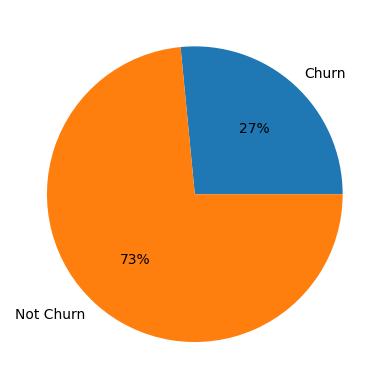

In [14]:
#let's take a look at our target label - "Churn" first
counts = [(df["Churn"] == 1).sum(), (df["Churn"] == 0).sum()]
plt.pie(counts, labels = ["Churn", "Not Churn"], autopct='%.0f%%')
plt.show()

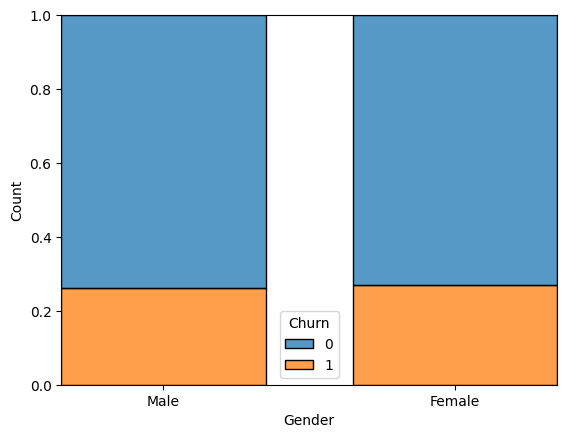

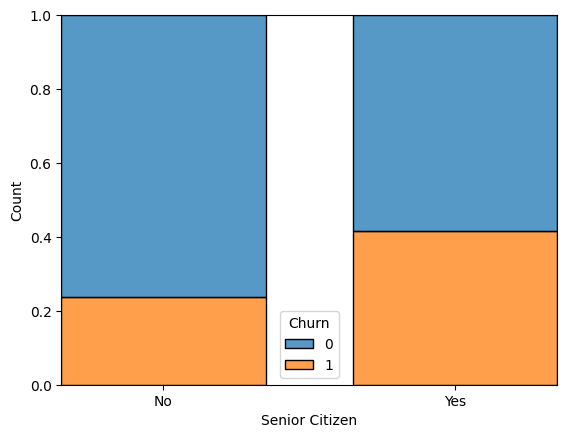

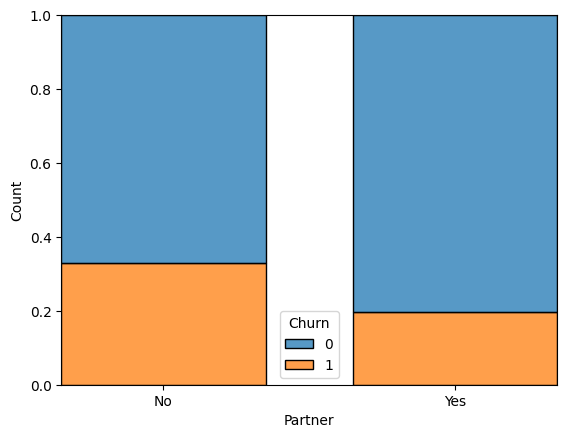

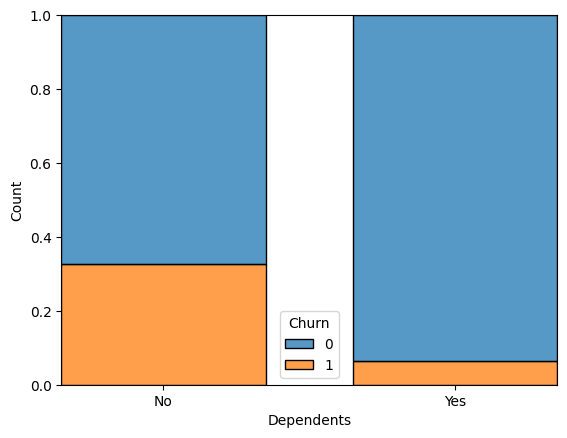

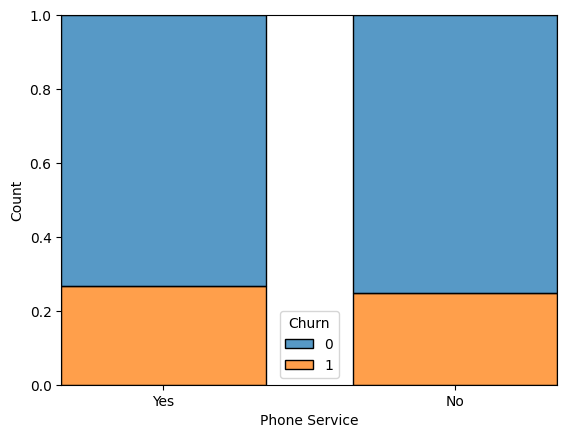

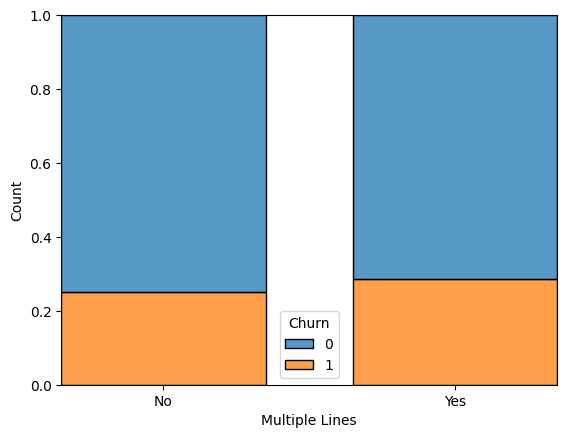

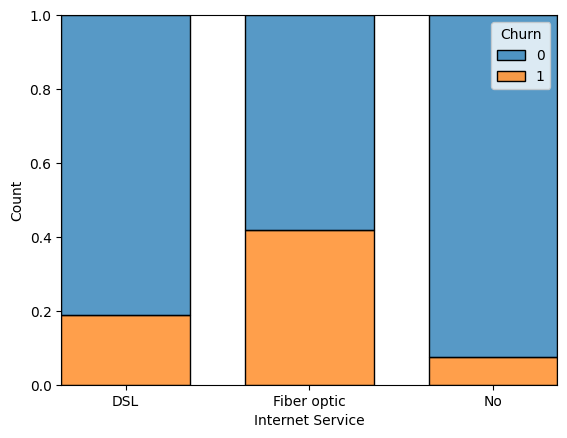

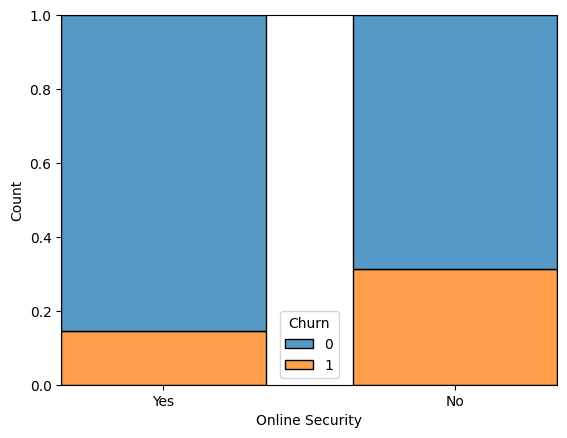

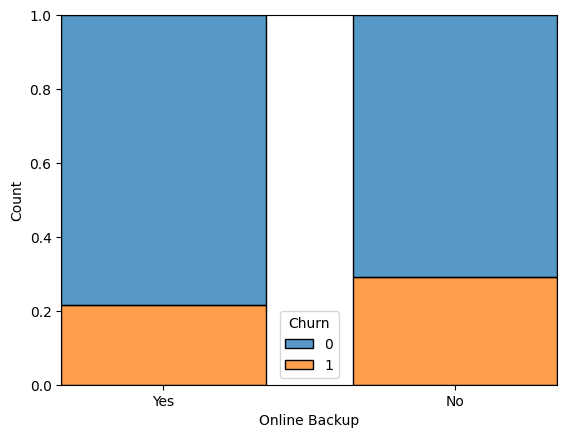

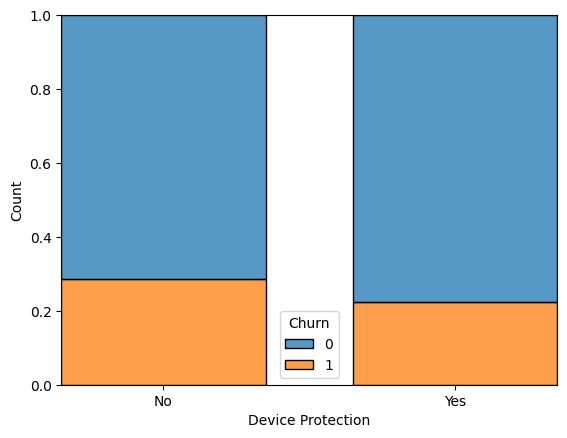

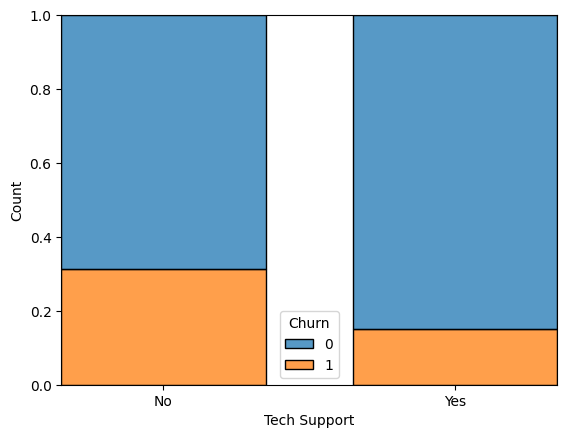

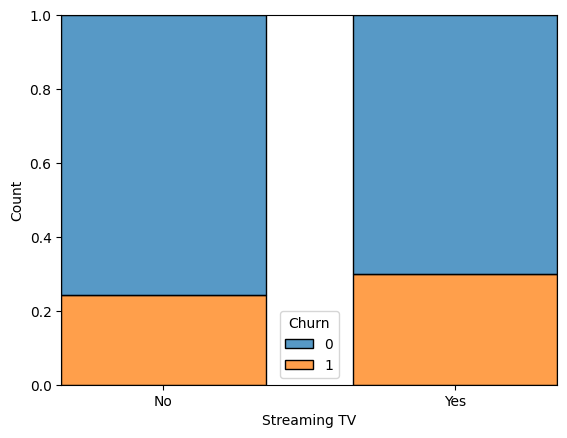

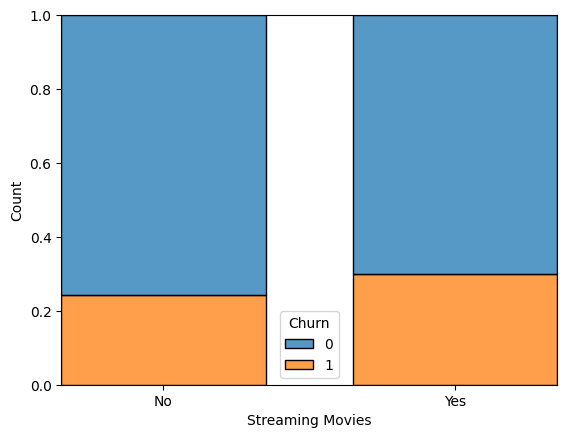

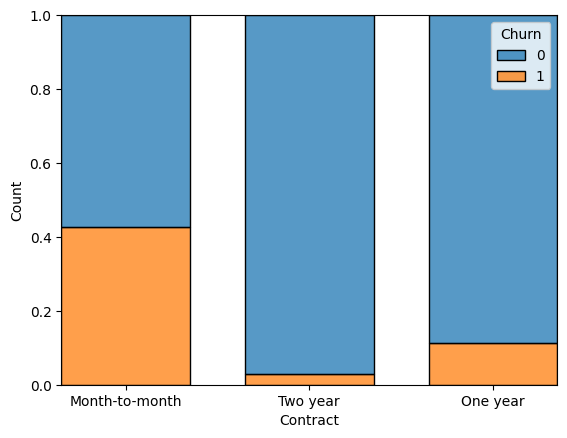

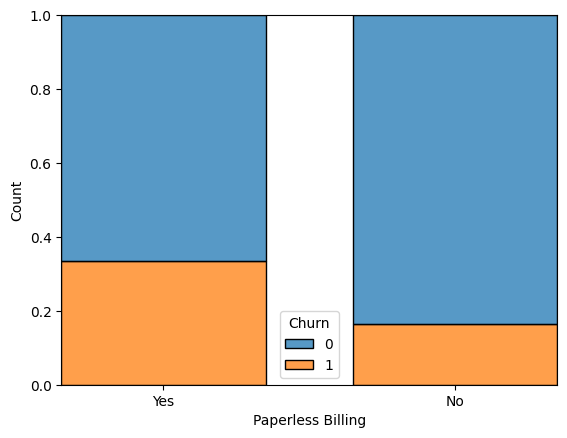

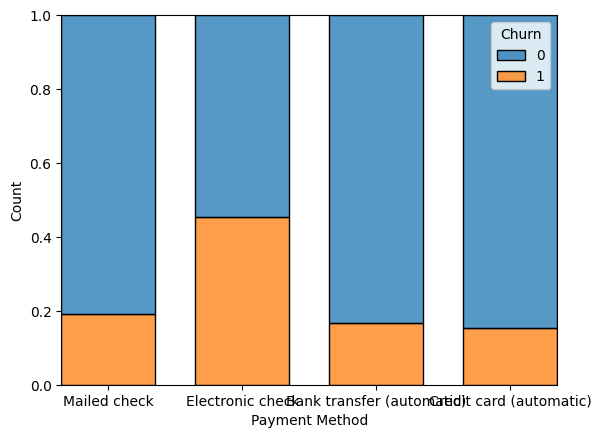

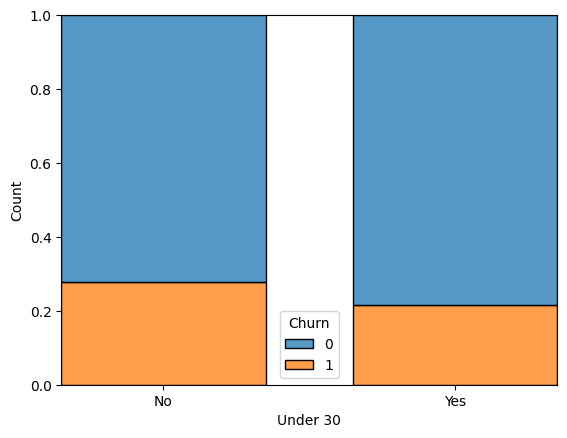

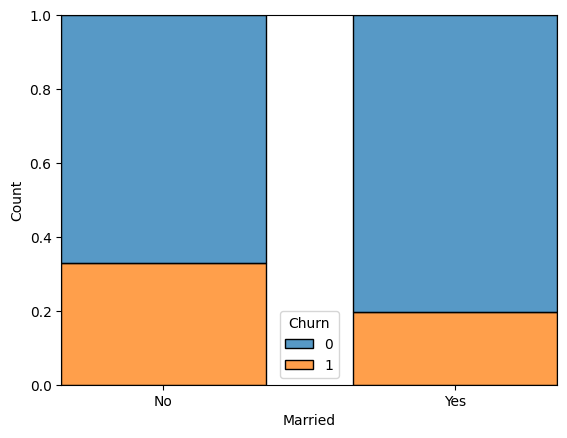

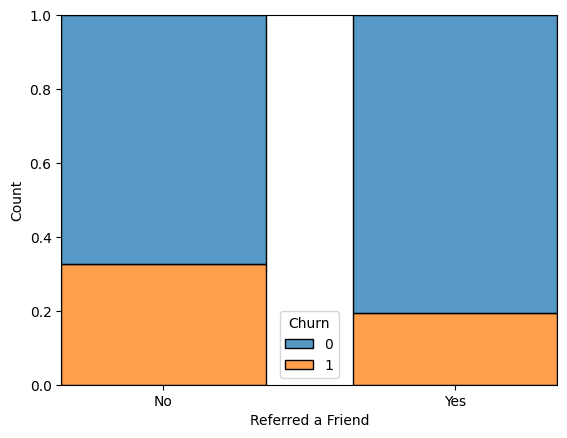

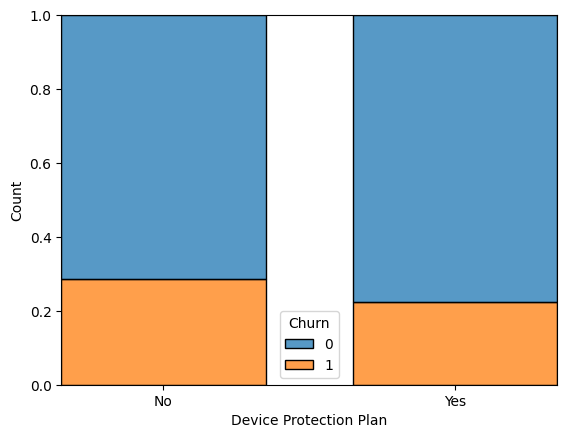

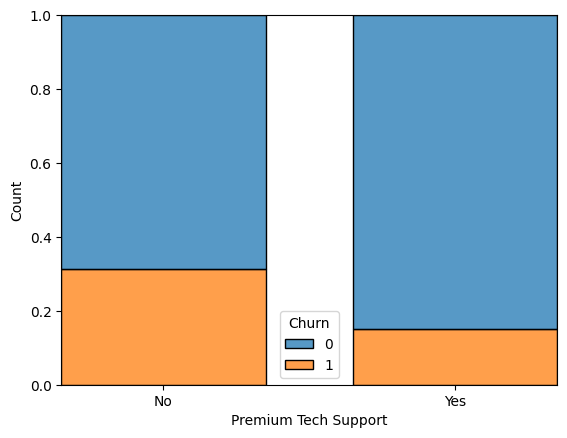

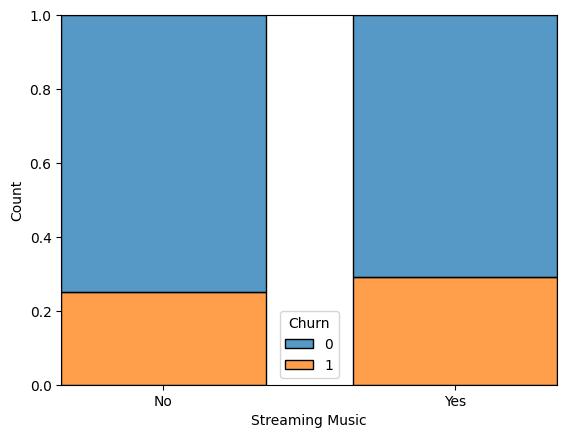

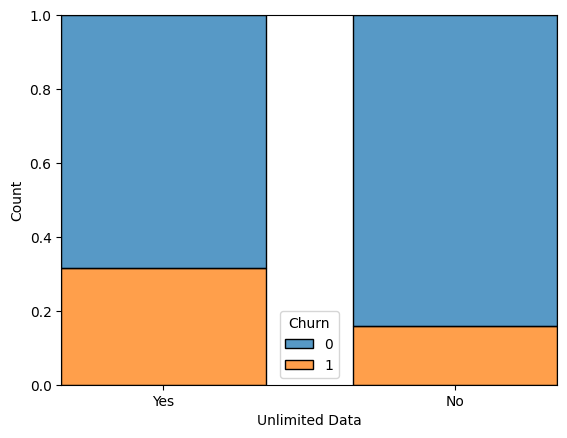

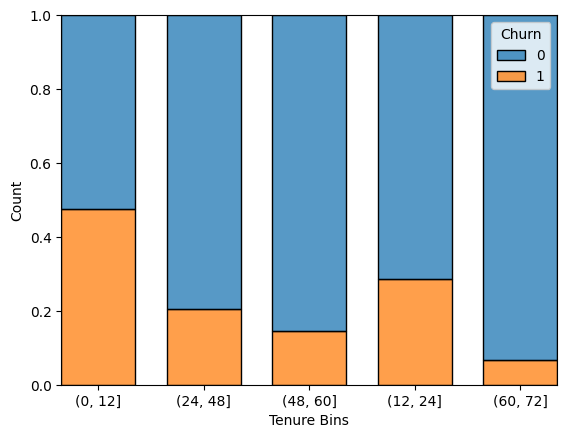

In [15]:
for col in df.columns.tolist():
    if col != "Churn" and df[col].dtype == 'object':
        plt.figure()
        sns.histplot(df, hue="Churn", x = col, shrink=.7, multiple="fill")
        plt.show()
    elif df[col].dtype == 'category':
        temp = df.copy()
        temp[col] = df[col].astype(str)
        plt.figure()
        sns.histplot(temp, hue="Churn", x = col, shrink=.7, multiple="fill")
        plt.show()

Despues de realizar el análisis, con cual de las siguientes afirmaciones estás de acuerdo? Justifica tu respuesta

### Observaciones:  
- El **"Satisfaction Score Label"** parece ser el mayor indicador de **Churn** (deserción), ya que casi todos los usuarios que califican nuestro servicio con un 1 o 2 tienen una alta probabilidad de darse de baja. Por lo tanto, debemos contactar a esos usuarios para recibir su retroalimentación y resolver cualquier problema. Además, los usuarios que califican con un 3 también tienen una posibilidad de desertar, por lo que las calificaciones de satisfacción de los usuarios deben tener una **prioridad muy alta**.

- El **"Género"** no parece tener un papel importante en la determinación de la deserción.

- Los **"Senior Citizens"** tienden a darse de baja más que otros.

- Las personas que tienen **'Fiber Optic' - "Internet service"** tienden a darse de baja más, lo que podría estar relacionado con el precio.

- Los clientes con un contrato **"Mes a mes"** tienden a desertar más que los que tienen otros tipos de contrato.

- En general, mientras mayor es la **"Antigüedad" (Tenure)** del cliente, menor es la probabilidad de deserción.



6. Analiza la siguiente matriz de correlación e identifica las variables que se podrian retirar del dataset

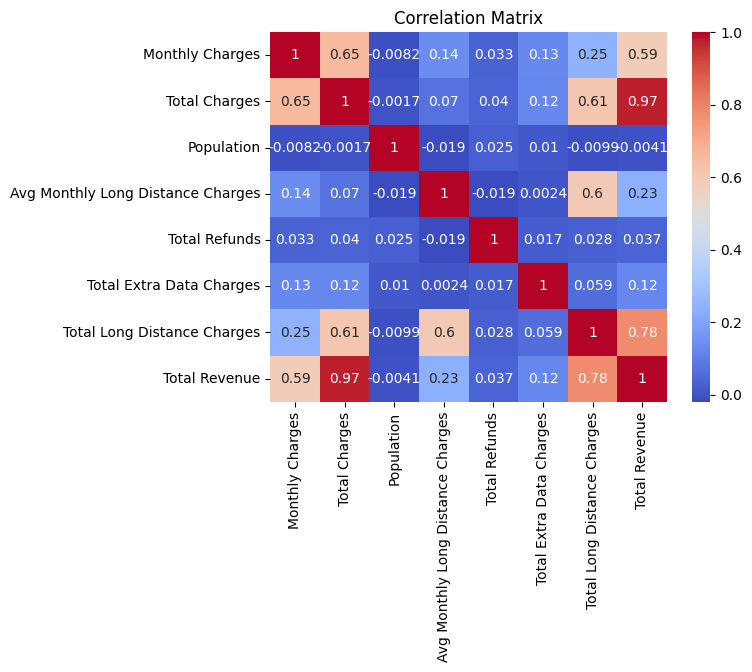

In [16]:
# Check the correlation matrix of all features
columns_for_corr = ["Monthly Charges", "Total Charges", "Population", "Avg Monthly Long Distance Charges", "Total Refunds", 
                    "Total Extra Data Charges", "Total Long Distance Charges", "Total Revenue"]
df_corr = df[columns_for_corr].corr()
sns.heatmap(df_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Observaciones:

Las columnas **"Total Charges"** y **"Total Revenue"** están **altamente correlacionadas**, como era de esperarse por sus nombres. Por lo tanto, mantendremos solo una de ellas, **"Total Revenue"**, y eliminaremos la otra.

Las columnas **"Monthly Charges"** y **"Total Long Distance Charges"** también están correlacionadas con **"Total Revenue"**, así que podríamos considerar **eliminarlas también**.

In [17]:
#Columns to be droped 
columns_to_be_dropped = ["Total Charges", "Monthly Charges", "Total Long Distance Charges"]
df.drop(columns_to_be_dropped, axis = 1, inplace = True)

7. Utiliza **One-Hot Encoding** para las variables Categoricas

In [18]:
# donde veamos "Yes" y "No" ponemos 1 y 0
columns_to_be_encoded = []
for col in df.columns.tolist():
    if(df[col].dtype == 'object' and "Yes" in df[col].unique()):
        columns_to_be_encoded.append(col)

df[columns_to_be_encoded] = np.where(df[columns_to_be_encoded] == "Yes", 1, 0)
df[columns_to_be_encoded] = df[columns_to_be_encoded].astype(int)


También necesitamos codificar de forma ordinal la columna **"Gender"**, de **"Male"** y **"Female"** a **0** y **1** para la codificación one-hot.


In [19]:
df["Gender"] = np.where(df["Gender"] == "Female", 1, 0)
df["Gender"] = df["Gender"].astype(int)

Utiliza **One-Hot encoding** para las siguientes variables: "Tenure Bins",  "Payment Method", "Contract", "Internet Service"

In [20]:
df = pd.get_dummies(df, columns = ["Tenure Bins",  "Payment Method", "Contract", "Internet Service"])

Separa la variable objetivo del resto de variables

In [21]:
X = df.drop(["Churn"], axis = 1)
y = df["Churn"]

In [22]:
#format the features names:
X.index.names = ['Customer_ID']
X.columns = [col.replace(' ', '_') for col in X.columns.tolist()]
X.columns = [col.replace('(', '_') for col in X.columns.tolist()]
X.columns = [col.replace(')', '') for col in X.columns.tolist()]
X.columns = [col.replace(']', '_') for col in X.columns.tolist()]
X.columns = [col.replace(',', '') for col in X.columns.tolist()]



Sepaa tu conjunto de prueba del conjunto de entrenamiento usando una relación 80% - 20%

In [23]:
# using the train test split function
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42, test_size = 0.2, shuffle = True)

Entrena un modelo de regresión logistica. Mide el accuracy y calcula la matriz de confusión


For Training Set:

accuracy_train: 0.9609513667021654

Confusion Matrix:


C:\Users\16079220\AppData\Local\anaconda3\envs\bancow2\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


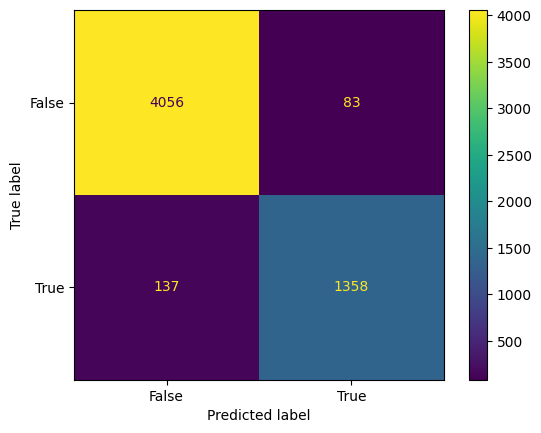

For Test Set:

accuracy_test: 0.9552874378992193

Confusion Matrix:


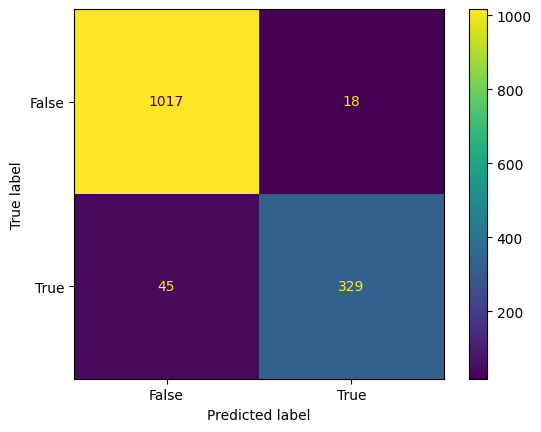

In [25]:
model1= LogisticRegression(random_state = 42, max_iter = 10000)
model1.fit(X_train, y_train)
print("\nFor Training Set:")
y_train_pred = model1.predict(X_train)
#f1_train = f1_score(y_train, y_train_pred, average='macro')
accuracy_train = accuracy_score(y_train, y_train_pred)
print("\naccuracy_train:", accuracy_train)

print("\nConfusion Matrix:") 
confusion_matrix = metrics.confusion_matrix(y_train, y_train_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

print("For Test Set:")
y_test_pred = model1.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
#f1_test = f1_score(y_test, y_test_pred, average='macro')
print("\naccuracy_test:", accuracy_test)

#recall_test_score = recall_score(y_test, y_test_pred, average='macro')
    
print("\nConfusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
 